# pyMelt_MultiNest interpreter

#### K. Wong, Università di Bologna, November 2023

This notebook is for understanding how to manipulate the data generated from pyMelt_Multinest. While immediate interpretation is provided in the 'summary.txt' and 'stats.json' files of the inversion folder and by running the code 'multinest_marginals.py', here I demonstrate how one can use the MultiNest outputs to make their own plots. These should be considered examples, and do adapt this code to perform your own analyses. This demo uses pyMelt v2.0.

We start by importing the relevant modules we will need and specifying the working directory.

In [1]:
import pyMelt as m
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import os

workDir = './pyMelt_demoFiles'  # Change this as necessary

We now identtify the folders in the working directory and create an export folder to store our outputs.

In [2]:
# Find folders in pyMelt folder
subfolders = [f.path for f in os.scandir(workDir) if f.is_dir()]

# Create export folders
if not os.path.exists(workDir +'/export'): 
    os.makedirs(workDir +'/export')
    
# Separate working folders from every other potential folder present (you may need to change this as necessary)
workFolders = [i for i in subfolders if 'export' not in i]
workFolders = [i for i in workFolders if 'pycache' not in i]

## 1. Inversion solution statistics

In this section, we will do some statistics on our imported inversion results and export the results to a csv file. The relevant file the inversion results are saved to is 'post_equal_weights.dat', in which the columns correspond to those in the 'params.json' file.

In [3]:
# Iterate over all inversion folders in the working directory
for i in range(len(workFolders)):

    # Assign our work folder
    workFolder = workFolders[i]

    # Get the parameters we have been working with and save them to a list
    paramsFile = open(workFolder + '/params.json')
    headers = json.load(paramsFile)
    paramsFile.close()

    # The post_equal_weights.dat file will have an extra column, which is a measure of misfit
    headers.append('log-likelihood')

    # We can open the post_equal_weights.dat file with pandas, and assign our headers
    data = pd.read_csv(workFolder + '/post_equal_weights.dat', header=None, delim_whitespace=True)
    data.columns = headers
    
    # Our inversion solutions are now stored in the pd.DataFrame 'data'. We can do statistics to reduce
    # this data to something manageable. Let's start by calculating medians, the 2.5th percentile, and
    # the 97.5th percentile (the latter two corresponding to the 95% uncertainty interval, or 2-sigma).
    median = []
    lowerPercentile = []
    upperPercentile = []

    for j in range(len(headers)):
        variable = headers[j]
        
        # Just make sure we don't do the median of the log-likelihood (which is meaningless)
        if variable == 'log-likelihood':
            continue
        variableMedian = np.median(data[variable])
        lower, upper = np.percentile(data[variable], [2.5 ,97.5])
        
        # Store in lists
        median.append(variableMedian)
        lowerPercentile.append(lower)
        upperPercentile.append(upper)
    
    # Amend our headers for csv export:
    exportHeaders = headers[:-1]
    headersLower = [j + '2.5' for j in exportHeaders]
    headersUpper = [j + '97.5' for j in exportHeaders]
    exportHeaders = exportHeaders + headersLower + headersUpper
    exportHeaders.append('Folder')
    
    # Combine our data lists
    exportList = median + lowerPercentile + upperPercentile
    exportList.append(workFolder)
    
    # Create csv file for our data
    if i == 0:
        exportDF = pd.DataFrame([exportList])
        exportDF.columns = exportHeaders
    else:
        tempExportDF = pd.DataFrame([exportList])
        tempExportDF.columns = exportHeaders
        exportDF = pd.concat([exportDF, tempExportDF])

# Export our data to a csv
exportDF.to_csv(workDir + '/export/export.csv', index=False)

## 2. Violin plots of Tp and hexplots of mantle lithology

Here we shall make some plots from the 'post_equal_weights.dat' file. Here we will consider only the first folder of inversion results.

Firstly, we will need to find a way to plot our proportions in a Cartesian system.

In [4]:
def ternary(A, B, C):
    """
    Create Cartesian coordinates from ternary proportions, with corners defined as follows:
      B
     / \
    A - C
    
    Inputs
    ------
    A, B, C : floats
        Proportions of A, B, and C.
    
    Outputs
    -------
    [x, y] : list
        Cartesian coordinates corresponding to proportions.
    """

    total = A + B + C
    b = B / total
    c = C / total
    x = c + b / 2
    y = b * np.sqrt(3 / 4)
    return [x, y]

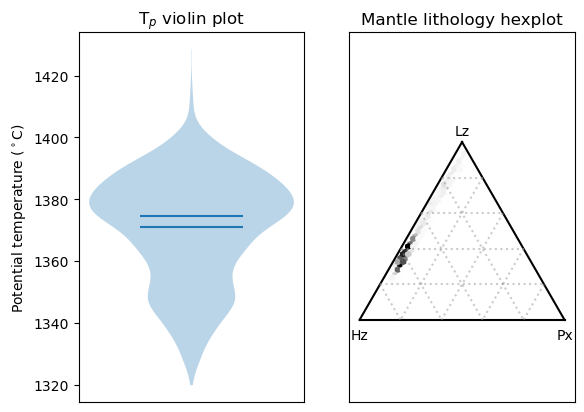

In [5]:
# Assign working folder
workFolder = workFolders[0]

# Get the parameters we have been working with and save them to a list
paramsFile = open(workFolder + '/params.json')
headers = json.load(paramsFile)
paramsFile.close()

# The post_equal_weights.dat file will have an extra column, which is a measure of misfit
headers.append('log-likelihood')

# We can open the post_equal_weights.dat file with pandas, and assign our headers
data = pd.read_csv(workFolder + '/post_equal_weights.dat', header=None, delim_whitespace=True)
data.columns = headers

# Create our figure object
fig1, ax1 = plt.subplots(1, 2)

# Let's start with the violin plot of Tp
position = [1.0]
ax1[0].violinplot(data['Tp'], position, showmedians=True, showmeans=True, showextrema=False)

# Formatting the plot
ax1[0].set_xticks([])
ax1[0].set_ylabel('Potential temperature ($^\circ$C)')


# Now time for the ternary plot. You may want to play around with the parameters to ensure that the plot is equilateral.
# Extract our lithological data
Fpx = data['F_px'].tolist()
Fhz = data['F_hz'].tolist()
Flz = [1 - (x + y) for x, y in zip(Fpx, Fhz)]
value_list = [ternary(Fhz[i], Flz[i], Fpx[i]) for i in range(len(Fpx))]
x_values = [item[0] for item in value_list]
y_values = [item[1] for item in value_list]

# Plot our hexbin
ax1[1].plot([0, 1], [0, 0], c='k', zorder=1)
ax1[1].plot([0, 0.5], [0, np.sqrt(3/4)], c='k', zorder=1)
ax1[1].plot([0.5, 1], [np.sqrt(3/4), 0], c='k', zorder=1)

# Add some decorations and gridlines
ax1[1].set_xticks([])
ax1[1].set_yticks([])

for i in range(5):
    if i == 0:
        continue
    x1 = i/10
    x2 = i/5
    y = np.sqrt(3) * x1
    ax1[1].plot([x1, 1 - x1], [y, y], ':', c=(0.6, 0.6, 0.6), alpha=0.5, zorder=1)
    ax1[1].plot([x1, x2], [y, 0],  ':', c=(0.6, 0.6, 0.6), alpha=0.5, zorder=1)
    ax1[1].plot([1 - x1, 1 - x2], [y, 0],  ':', c=(0.6, 0.6, 0.6), alpha=0.5, zorder=1)


ax1[1].text(0, -0.04, 'Hz', ha = 'center', va='top')
ax1[1].text(0.5, np.sqrt(3/4)+0.02,'Lz', ha = 'center', va='bottom')
ax1[1].text(1, -0.04, 'Px', ha = 'center', va='top')
hb = ax1[1].hexbin(x_values, y_values, gridsize=40, cmap='Greys', mincnt=1,
                   extent=(0, 1, 0, np.sqrt(3/4)), zorder=0)

# Hide the white square behind the plot
ax1[1].patch.set_alpha(0)

# Squish the plot so it appears more equilateral
ax1[1].set_ylim(-0.4, 1.4)

# Some labels
ax1[0].title.set_text('T$_p$ violin plot')
ax1[1].title.set_text('Mantle lithology hexplot')

plt.show()

## 3. Creating forward models using pyMelt from the medians and random solutions

Here we will create some forward models, both using the medians of the solutions (which itself is not a solution) and also from 20 random solutions.

In [6]:
# Generate forward results from medians

# We will firstly import our data from the csv generated in Part 1
# We will only consider the data from the first inversion
dataResults = pd.read_csv(workDir + '/export/export.csv')

lz = m.lithologies.matthews.klb1()
px = m.lithologies.matthews.kg1()
hz = m.lithologies.shorttle.harzburgite()

data = dataResults.iloc[0]

# When creating our mantle, column, and geosetting, we will pull data from the inversion medians
# See the pyMelt readthedocs for more info
mantle = m.mantle([lz, px, hz], [(1 - (data['F_px'] + data['F_hz'])), data['F_px'], data['F_hz']], ['lz', 'px', 'hz']) 
column = mantle.adiabaticMelt(Tp=data['Tp'])
column.calculateChemistry(
    elements={'lz': {'La': data['La_lz'],
                     'Dy': data['Dy_lz'],
                     'Yb': data['Yb_lz']},
              'px': {'La': data['La_px'],
                     'Dy': data['Dy_px'],
                     'Yb': data['Yb_px']},
              'hz': m.chemistry.workman05_dmm},
    cpxExhaustion={'lz': 0.18,
                   'px': 0.70,
                   'hz': 0.10},
    garnetOut={
        'lz': m.chemistry.mineralTransition_linear(
            {'gradient': 1/666.7, 'intercept': 400/666.7}),
        'px': m.chemistry.mineralTransition_isobaric(
            {'transition_pressure': 1.5}),
        'hz': m.chemistry.mineralTransition_isobaric(
            {'transition_pressure': 1.5}),
                 },
    spinelIn={
        'lz': m.chemistry.mineralTransition_linear(
            {'gradient': 1/666.7, 'intercept': 533/666.7}),
        'px': m.chemistry.mineralTransition_isobaric(
            {'transition_pressure': 2.5}),
        'hz': m.chemistry.mineralTransition_isobaric(
            {'transition_pressure': 2.5}),
                 },
    mineralProportions={'lz': m.chemistry.klb1_MineralProportions,
                        'px': m.chemistry.kg1_MineralProportions,
                        'hz': m.chemistry.klb1_MineralProportions}
)



geosetting = m.geosettings.spreadingCentre(column)

# These values can now be exported and compared to other data
TcrysMin, TcrysMax = geosetting.meltCrystallisationT()
crustalThickness = geosetting.tc
chemistryList = [geosetting.chemistry['La'], geosetting.chemistry['Dy'], geosetting.chemistry['Yb']]

C:\Users\kevwo\anaconda3\lib\site-packages\pyMelt\mantle_class.py:476: UserWarning: Freezing prevented.
  _warn("Freezing prevented.")


KeyError: 'yb'

In [ ]:
# Extracting some random solutions - this may take time to run depending on how many solutions are extracted

# Assign working folder
workFolder = workFolders[0]

# Get the parameters we have been working with and save them to a list
paramsFile = open(workFolder + '/params.json')
headers = json.load(paramsFile)
paramsFile.close()

# The post_equal_weights.dat file will have an extra column, which is a measure of misfit
headers.append('log-likelihood')

# We can open the post_equal_weights.dat file with pandas, and assign our headers
data = pd.read_csv(workFolder + '/post_equal_weights.dat', header=None, delim_whitespace=True)
data.columns = headers


randomRows = np.random.default_rng().choice(len(data), size=20, replace=False)

In [ ]:
# Lists for storage
TcrysData = []
tcData = []
LaData = []
DyData = []
YbData = []

# Iterate over our random rows selected above
for i in range(20):
    dataRow = data.iloc[randomRows[i]]
    
    # Use the same conditions as above
    mantle = m.mantle([lz, px, hz], [(1 - (dataRow['F_px'] + dataRow['F_hz'])), dataRow['F_px'], dataRow['F_hz']], ['lz', 'px', 'hz']) 
    column = mantle.adiabaticMelt(Tp=dataRow['Tp'])
    column.calculateChemistry(
        elements={'lz': {'La': dataRow['La_lz'],
                         'Dy': dataRow['Dy_lz'],
                         'Yb': dataRow['Yb_lz']},
                  'px': {'La': dataRow['La_px'],
                         'Dy': dataRow['Dy_px'],
                         'Yb': dataRow['Yb_px']},
                  'hz': m.chemistry.workman05_dmm},
        cpxExhaustion={'lz': 0.18,
                       'px': 0.70,
                       'hz': 0.10},
        garnetOut={
            'lz': m.chemistry.mineralTransition_linear(
                {'gradient': 1/666.7, 'intercept': 400/666.7}),
            'px': m.chemistry.mineralTransition_isobaric(
                {'transition_pressure': 1.5}),
            'hz': m.chemistry.mineralTransition_isobaric(
                {'transition_pressure': 1.5}),
                     },
        spinelIn={
            'lz': m.chemistry.mineralTransition_linear(
                {'gradient': 1/666.7, 'intercept': 533/666.7}),
            'px': m.chemistry.mineralTransition_isobaric(
                {'transition_pressure': 2.5}),
            'hz': m.chemistry.mineralTransition_isobaric(
                {'transition_pressure': 2.5}),
                     },
        mineralProportions={'lz': m.chemistry.klb1_MineralProportions,
                            'px': m.chemistry.kg1_MineralProportions,
                            'hz': m.chemistry.klb1_MineralProportions}
    )
    geosetting = m.geosettings.spreadingCentre(column)
    TcrysMin, TcrysMax = geosetting.meltCrystallisationT()
    crustalThickness = geosetting.tc
    
    TcrysData.append([TcrysMin, TcrysMax])
    tcData.append(crustalThickness)
    LaData.append(geosetting.chemistry['La'])
    DyData.append(geosetting.chemistry['Dy'])
    YbData.append(geosetting.chemistry['Yb'])